# Features Visualization

## Setup

In [1]:
import torch
import requests
from torchvision import transforms, models
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm 

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


In [3]:
model = models.resnet18(pretrained = True)
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/fozame/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fozame/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


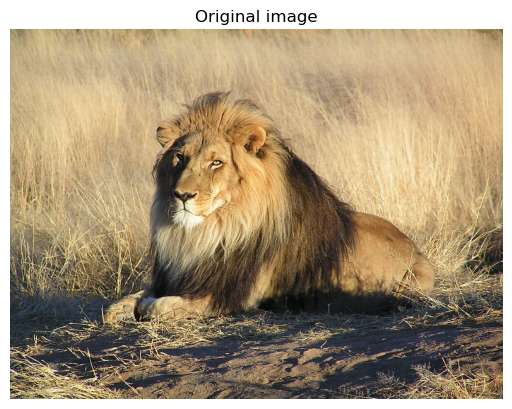

In [4]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Lion_waiting_in_Namibia.jpg/1024px-Lion_waiting_in_Namibia.jpg"
image = Image.open(requests.get(url, stream = True).raw).convert("RGB")
plt.title("Original image")
plt.axis('off')
plt.imshow(image)

## Visualization

In [5]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = 0, std = 1.)
])

In [6]:
model_weights = []
conv_layers = []
count = 0
model_children = list(model.children())
for i in tqdm(range(len(model_children)), ascii = True):
    if type(model_children[i]) == torch.nn.Conv2d:
        count += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == torch.nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == torch.nn.Conv2d:
                    count += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
        

print("-"*20)
print(f"The model used {count} convolution layers")
for conv in conv_layers:
    print(conv)

100%|##########| 10/10 [00:00<00:00, 44197.09it/s]

--------------------
The model used 17 convolution layers
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

In [7]:
image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [8]:
outputs = []
names = []
results = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))

for feature_map in tqdm(outputs, ascii = True):
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    results.append(gray_scale.data.cpu().numpy())



100%|##########| 17/17 [00:00<00:00, 7489.04it/s]


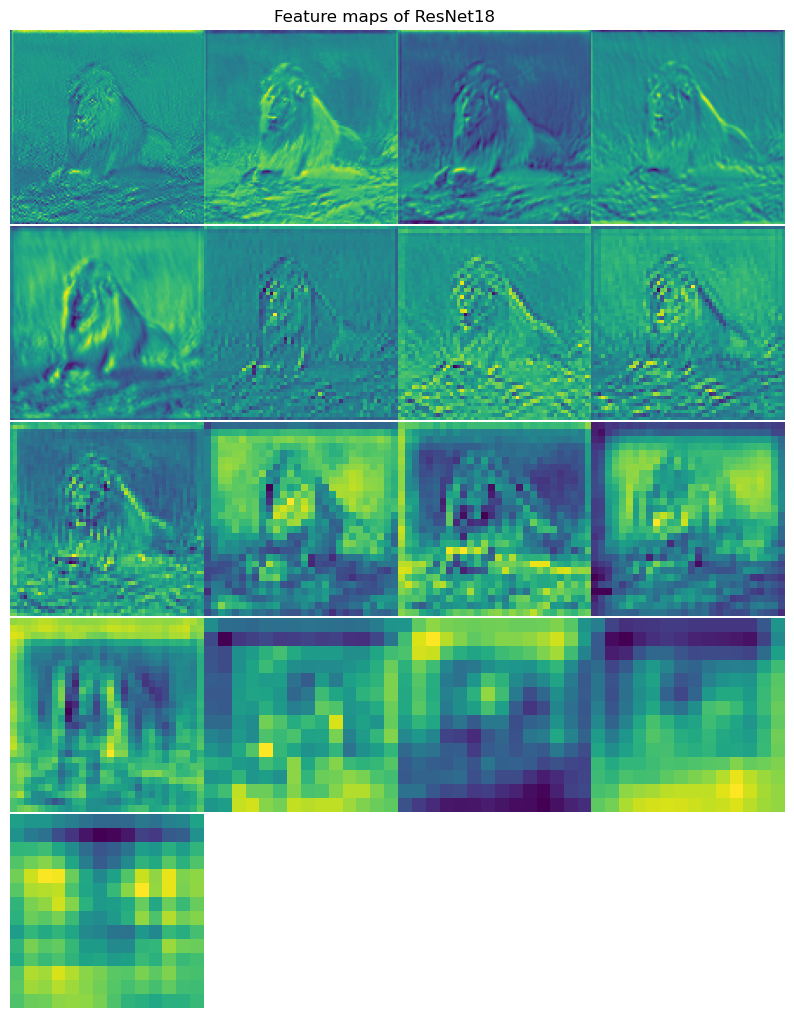

In [9]:
fig = plt.figure(figsize=(10,20))
fig.suptitle("Feature maps of ResNet18", y=0.61)
fig.subplots_adjust(wspace=0.001, hspace=0.001, top=0.6)
for i in range(len(results)):
    a = fig.add_subplot(5,4,i+1)
    plot = plt.imshow(results[i])
    a.axis('off')

plt.show()